In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import SVD
from collections import defaultdict
sns.set()

In [7]:
!ls *.csv

credits_clean.csv
keywords_clean.csv
links_clean.csv
metadata_clean.csv


In [8]:
links = pd.read_csv('links_clean.csv')
ratings = pd.read_csv(r'the-movies-dataset\ratings_small.csv')
meta = pd.read_csv('metadata_clean.csv')
meta['id'] = meta.id.astype(int)
#merged = pd.merge(ratings, meta, left_on = 'movieId', right_on='id')
#merged = merged[['userId', 'movieId', 'rating', 'title']]

In [9]:
ratings = pd.merge(links, ratings, on='movieId')[['userId', 'tmdbId', 'rating']]

In [10]:
ratings.head()

,userId,tmdbId,rating
0,7,862,3.0
1,9,862,4.0
2,13,862,5.0
3,15,862,2.0
4,19,862,3.0


In [11]:
# loading the data and specifying the train and test set
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'tmdbId', 'rating']], reader = reader)

train = data.build_full_trainset()
test = train.build_anti_testset()

## Recommender system using SVD algorithm

In [8]:
# using the cross validation to get a sense of optimum factor to minimize the RMSE
factor = range(1, 30)
scores = []
for f in factor:
    model = SVD(n_factors=f)
    score_cv = cross_validate(model, data, measures=['rmse'], cv=5)
    score = score_cv['test_rmse'].mean()
    scores.append(score)

Text(0, 0.5, 'RMSE')

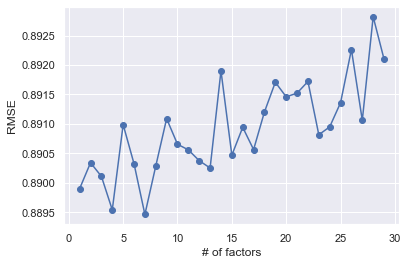

In [9]:
plt.plot(factor, scores, marker='o')
plt.xlabel('# of factors')
plt.ylabel('RMSE')

In [13]:
# using grid search to choose the best number of factors
params = {'n_factors':[4, 7, 8, 9, 13, 15, 17]}
gs = GridSearchCV(SVD, param_grid=params, measures=['rmse'])

In [14]:
gs.fit(data)

In [15]:
# best number of factors based on grid search method
gs.best_params

{'rmse': {'n_factors': 7}}

In [16]:
gs.best_score

{'rmse': 0.8896514728769889}

**best RMSE score using the SVD algorithm is .89**

In [12]:
model = SVD(n_factors = 7)
model.fit(train)

In [13]:
pred = model.test(test)

In [14]:
def top_recomm(predictions, userid, ratings_df, meta_data, n_top = 10 ):
    '''using the predicted values on the data, the function 
       returns the n_top predicted ratings for the specific user,
       and also the n_top rated movies for the user
    '''
    
    pred_dict = defaultdict(list)
    for user, movieid, rate, est, _ in predictions:
        pred_dict[user].append((movieid, est))
    
    for user, items in pred_dict.items():
        items.sort(key = lambda x:x[1], reverse=True)
        pred_dict[user] = items[:n_top]    
    
        
    movies, rate_est = zip(*pred_dict[userid])
    suggest_df = pd.DataFrame({'tmdbId':movies, 'ratings':rate_est})
    suggest_df = pd.merge(meta_data, suggest_df, how='right', left_on = 'id', right_on = 'tmdbId')[['tmdbId', 'title','ratings']]
    suggest_df.sort_values(by='ratings', ascending=False, inplace=True)
    
    hist_df = ratings_df[ratings_df['userId']==userid]
    hist_df.sort_values(by='rating', ascending=False, inplace=True)
    hist_df = hist_df[:n_top]
    hist_df = pd.merge(meta_data, hist_df, how='right', left_on = 'id', right_on = 'tmdbId')[['tmdbId', 'title','rating']]
    hist_df.sort_values(by='rating', ascending=False, inplace=True)
    
    return suggest_df, hist_df
        
    
    

In [15]:
# predicting the ratings for the users
sugg, hist = top_recomm(pred, 10, ratings, meta, n_top=10)

C:\Users\amir\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Top 10 suggestions using SVD

In [16]:
# top 10 suggested movies for user with user_id of 10, using SVD algorithm
sugg

,tmdbId,title,ratings
5,238,The Godfather,4.522832
3,488,The African Queen,4.511930
8,1779,Roger & Me,4.503951
0,3078,It Happened One Night,4.475844
2,705,All About Eve,4.458922
7,11645,Ran,4.455192
1,963,The Maltese Falcon,4.452684
6,1578,Raging Bull,4.449585
4,654,On the Waterfront,4.434210
9,598,City of God,4.430938


### Top 10 movies ranked by the user

In [36]:
# top 10 ratings, given by the user with user_id 10
hist.rename(columns={'rating':'ratings'}, inplace=True)
hist

,tmdbId,title,ratings
0,11893,Runaway Train,5.0
1,11054,Hairspray,5.0
3,468,My Own Private Idaho,5.0
4,629,The Usual Suspects,5.0
5,12498,Sling Blade,5.0
6,10217,The Sweet Hereafter,5.0
7,544,There's Something About Mary,5.0
8,603,The Matrix,5.0
9,1911,The 13th Warrior,5.0
2,476,Drugstore Cowboy,4.0


## Recommender system using NMF algorithm

In [18]:
from surprise import NMF

In [10]:
factor = range(1, 30)
scores2=[]
for i in factor:
    model = NMF(n_factors = i)
    score_cv = cross_validate(model, data, measures=['rmse'], cv=5)
    score = score_cv['test_rmse'].mean()
    scores2.append(score)

Text(0.5, 1.0, 'NMF')

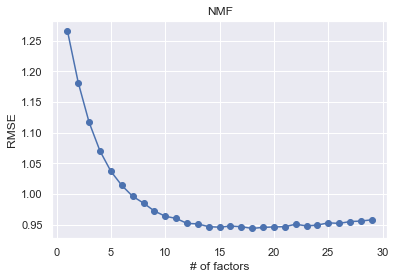

In [31]:
plt.plot(factor, scores2, marker='o')
plt.xlabel('# of factors')
plt.ylabel('RMSE')
plt.title('NMF')

In [15]:
params = {'n_factors':range(12, 18)}
gs2 = GridSearchCV(NMF, param_grid = params, measures=['rmse'])

In [16]:
gs2.fit(data)

In [17]:
gs2.best_params

{'rmse': {'n_factors': 17}}

In [28]:
gs2.best_score

{'rmse': 0.9461077057042182}

**best RMSE score using NMF algorithm is .95**

In [19]:
nmf = NMF(n_factors=17)
nmf.fit(train)
nmf_pred = nmf.test(test)

In [20]:
sugg_nmf, hist = top_recomm(nmf_pred, 10, ratings, meta, n_top = 10 )

C:\Users\amir\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Top 10 suggestions using NMF

In [21]:
# Top 10 suggested movies for user with user_id of 10, using NMF algorithm
sugg_nmf

,tmdbId,title,ratings
0,7452,"The Cook, the Thief, His Wife & Her Lover",5
1,11104,Chungking Express,5
2,46785,The White Balloon,5
3,85778,Maya Lin: A Strong Clear Vision,5
4,11159,Secrets & Lies,5
5,43771,Gabbeh,5
6,17139,Character,5
7,5910,Fireworks,5
8,30020,Taste of Cherry,5
9,10683,Happiness,5


**Comparing the performance of two algorithms of SVD and NMF, the SVD algorithm results in a slightly lower RMSE of 0.89 compared to 0.95 for NMF**

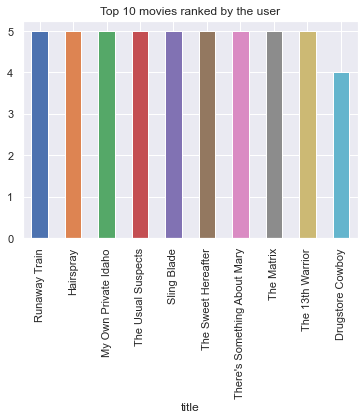

In [57]:
hist.plot(x='title', y='ratings', kind='bar', legend=False, title='Top 10 movies ranked by the user')
plt.savefig('user_ranked.jpg', bbox_inches='tight', dpi=1200)

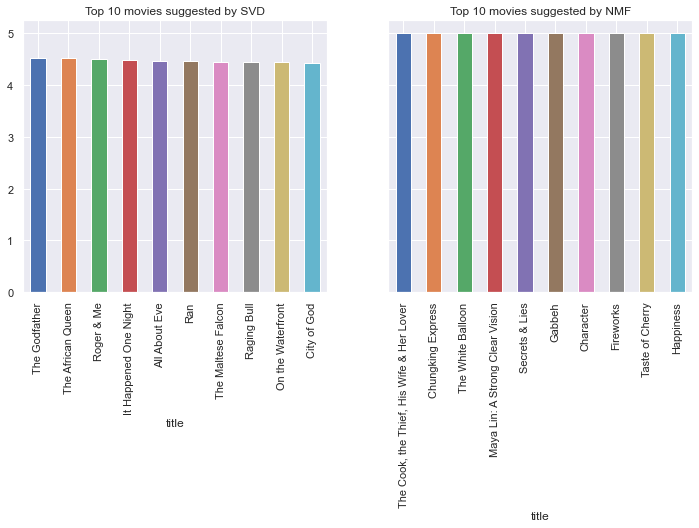

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
#hist.plot(x='title', y='ratings', kind='bar', legend=False, title = 'Top movies ranked by the user', ax=axes[0])
sugg.plot(x='title', y='ratings', kind='bar', legend=False, title = 'Top 10 movies suggested by SVD', ax=axes[0])
sugg_nmf.plot(x='title', y='ratings', kind='bar', legend=False, title = 'Top 10 movies suggested by NMF', ax=axes[1])
#plt.subplots_adjust(wspace=.05)
plt.savefig('svd_nmf.jpg', bbox_inches='tight', dpi=1200)